# Статистика 8

A/A-тесты — необходимый и полезный этап эксперимента, который позволяет убедиться, что наша система сплитования трафика не сломана. Нарушения в её работе могут привести к тому, что результат эксперимента будет объясняться не качеством гипотезы, а техническими проблемами.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('/home/jupyter-a-berezin-18/Statistics/Datasets/hw_aa.csv', sep = ';')

In [4]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [5]:
df.shape

(127018, 5)

1. Запустим тест

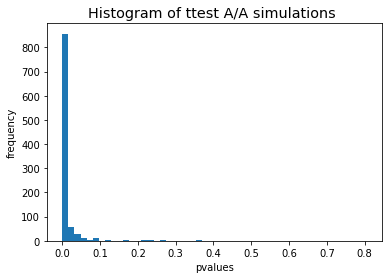

0.945

In [9]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

А/А тест не сходится

Посмотрим на состояние сплит - системы

In [22]:
df.groupby(['experimentVariant', 'version']).agg({'uid': 'count'})

uid
experimentVariant version        
0                 v2.8.0    41283
                  v2.9.0    11921
                  v3.7.4.0   4204
                  v3.8.0.0   5694
1                 v2.8.0    41552
                  v2.9.0    12033
                  v3.7.4.0   4221
                  v3.8.0.0   6110

В принципе, система отработала нормально

Посчитаем конверсию

In [17]:
df.groupby(['experimentVariant', 'version']).agg({'purchase': 'mean'})

purchase
experimentVariant version           
0                 v2.8.0    0.000993
                  v2.9.0    0.074658
                  v3.7.4.0  0.059943
                  v3.8.0.0  0.057604
1                 v2.8.0    0.045606
                  v2.9.0    0.071304
                  v3.7.4.0  0.063018
                  v3.8.0.0  0.062848

Сразу видно как конверсия для v2.8.0 варианта 0 отличается от той же версии из варианта 1. С учетом того, что сплит - система в норме, стало быть проблема в версии.

2. Посчитаем p - value для каждой версии 

v2.8.0

In [10]:
stats.kruskal(df[(df.experimentVariant == 0) & (df.version == "v2.8.0")]['purchase'],
               df[(df.experimentVariant == 1) & (df.version == "v2.8.0")]['purchase'])

KruskalResult(statistic=1805.650673266692, pvalue=0.0)

v2.9.0

In [11]:
stats.kruskal(df[(df.experimentVariant == 0) & (df.version == "v2.9.0")]['purchase'],
               df[(df.experimentVariant == 1) & (df.version == "v2.9.0")]['purchase'])

KruskalResult(statistic=0.9959238590542598, pvalue=0.3182988289101366)

v3.7.4.0

In [12]:
stats.kruskal(df[(df.experimentVariant == 0) & (df.version == "v3.7.4.0")]['purchase'],
               df[(df.experimentVariant == 1) & (df.version == "v3.7.4.0")]['purchase'])

KruskalResult(statistic=0.3451743701255238, pvalue=0.5568575965146383)

v3.8.0.0

In [13]:
stats.kruskal(df[(df.experimentVariant == 0) & (df.version == "v3.8.0.0")]['purchase'],
               df[(df.experimentVariant == 1) & (df.version == "v3.8.0.0")]['purchase'])

KruskalResult(statistic=1.4294525251706602, pvalue=0.23185380743578476)

p - value (v2.8.0) = 0.0 < 0.05, исключаем данные о этой версии из датафрейма и снова запускаем А/А тест

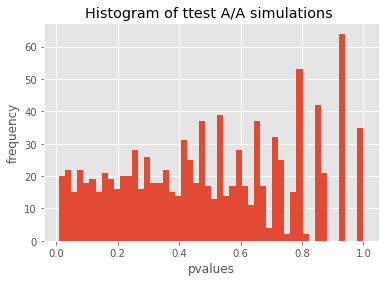

0.043

In [20]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.version != 'v2.8.0') & (df.experimentVariant == 1)]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.version != 'v2.8.0') & (df.experimentVariant == 0)]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Теперь тест сходится, поломка найдена.